In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
pip install catboost

     |████████████████████████████████| 67.3MB 65kB/s 


In [1]:
import pandas as pd
import numpy as np

import gc

from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import make_scorer
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import pickle
import dill
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error as mse
from typing import Union
from tqdm import tqdm

from xgboost import XGBRegressor 


import lightgbm as lgb

In [2]:
df= pd.read_pickle("/content/drive/MyDrive/final_data_from_2015_till_1969_with_encoding.pkl")

id_dict= pd.read_csv("/content/drive/MyDrive/ids_dict.csv")
id_dict= dict(zip(id_dict['id'], id_dict['uid']))

sales= pd.read_csv('/content/drive/MyDrive/sales_train_evaluation.csv')

In [4]:
'''here we are importing sales dataset and we are creating few column orders '''

d_cols= [col for col in sales.columns if 'd_' in col] 
non_d_cols= [col for col in sales.columns if 'd_' not in col] 

f_cols= [ ("F"+str(i+1)) for i in range(28)]
d_with_f_cols= d_cols+ f_cols

col_order= d_cols + ['level', 'weights']
col_order_with_f_cols= d_with_f_cols+['level', 'weights']
col_order_with_f_cols_without_level= d_with_f_cols+['weights']

uid= sales.id.unique() #getting all unique id's from test data

# in kaggle submission file we have to predict last 56 days data from day 1885 for each item
# getting validation ids for each item sales from day 1885 - day 1913
validation_uid= ["_".join(ids.split("_")[:-1] + ["validation"]) for ids in uid] 

In [5]:
'''splitting to train and test dataset'''

valid = df[df['d']<=1913][['id','d','sales', 'revenue']]
test = df[(df['d']>1913) & (df['d']<=1941)][['id','d','sales', 'revenue']]
evaluation= df[df['d']>1941]

valid['id']= valid['id'].apply(lambda x: id_dict[x])
test['id']= test['id'].apply(lambda x: id_dict[x])

valid_df= valid.groupby('id')
test_df= test.groupby('id')

### Metric

In [6]:
## correct one and currently using this finally -------------------------------------------modifications 4 finally correct

def get_level_12_weights(isvalidation):
    '''calculating last 28 day revenue and weights'''
    #if isvalidation = True, validation data will be from day 1857 -1885
    #if isvalidation= False, validation data will be from day 1885 -1913
    # print("calculating level 12 weights...")
    last_28_day_revenue= []
    weights= [] 
    
    if isvalidation:
        for i in uid: #uid= unique ids
            last_28_day_revenue.append(valid_df.get_group(i)['revenue'].dropna()[-56:-28].values.sum())

        for i in last_28_day_revenue:
            weights.append(i/ sum(last_28_day_revenue))
        
        return weights
    
    else:
        for i in uid: #uid= unique ids
            last_28_day_revenue.append(valid_df.get_group(i)['revenue'].dropna()[-28:].values.sum())

        for i in last_28_day_revenue:
            weights.append(i/ sum(last_28_day_revenue))
                        
        return weights
    
    
def calculate_weights(sales, prediction, aggregation_level, isvalidation):
    '''this function will calculate weights acc to level 12'''
    
#     temp part
    if isvalidation:
        weights= valid_weights
    else:
        weights= test_weights
   
#     https://www.youtube.com/watch?v=7FwITPrBvLI&list=PLu4R9FIFLvWmRgHTH2Br-Di6koS_D7oL7&index=3
#     weights= get_level_12_weights(isvalidation) #calling function, calculating weights
    sales['weights']= weights #adding weights
    sales= sales.merge(prediction, on= 'id', how='left') #sales with fcols(i.e prediction data)
    sales2= sales[col_order_with_f_cols_without_level] #creating another dataframe bcoz this dataframe values will be used ahead

    # print('calculating weights aggregate level...')

    #creating new dataframe to store aggregate data weights and revenue
    aggregation_data= pd.DataFrame(sales2.sum()).T
    aggregation_data['level']=1
    aggregation_data['weights']= 1/12
    ag_df= aggregation_data[col_order_with_f_cols]

    #iterating over all the agg levels
    for i in aggregation_level.keys(): #getting weights for all other levels
        temp= sales.groupby(aggregation_level[i]).sum().reset_index(drop=True)
        temp['level']= i
        temp['weights'] /= 12
        temp= temp[col_order_with_f_cols]
        aggregation_data= pd.concat([aggregation_data,temp])

    sale= sales2.copy()
    sale['weights'] /= 12
        
    return sale, aggregation_data



def rmsse(actual, predicted, historical):
    '''this function will calculate the rmsse values'''
    
    actual= np.array(actual)
    predicted= np.array(predicted)
    historical= np.array(historical)
    h= len(actual[0])
    n= len(historical[0])

    numerator= ((actual- predicted)**2).sum(axis=1)
    denominator= (1/n)*((historical[:, 1:] - historical[:, :-1]) ** 2).sum(axis=1)
    rmsses= np.sqrt((numerator/denominator) * (1/ h))
    return rmsses


    
def calculate_wrmsse(sale, aggregation_data, isvalidation):
    '''this function will calculate wrmsse'''
    
    if isvalidation:
        historical_cols= d_cols[:-56]
        actual_cols= d_cols[-56:-28]

        predicted_cols= f_cols
        
    else:
        historical_cols= d_cols[:-28]
        actual_cols= d_cols[-28:]
        predicted_cols= f_cols        

    # print('calculating rmsse...')

    
    rmsse_sale= rmsse(sale[actual_cols], sale[predicted_cols], sale[historical_cols])
    rmsse_agg= rmsse(aggregation_data[actual_cols], aggregation_data[predicted_cols], aggregation_data[historical_cols])
    
    # print('calculating wrmsse...')

    wrmsse_sale= rmsse_sale * sale['weights']
    wrmsse_agg= rmsse_agg * aggregation_data['weights']

    wrmsse= wrmsse_agg.sum() + wrmsse_sale.sum()
    return wrmsse



def wrmsse(sales, prediction, isvalidation):
    '''this function will call all other functions as requires so as to make work easier'''
    
    #all the aggregation levels present in the data
    aggregation_level = {2: ["state_id"], 3: ["store_id"], 4: ["cat_id"], 5: ["dept_id"], 6: ["state_id", "cat_id"], 
                         7: ["state_id", "dept_id"], 8: ["store_id", "cat_id"], 
                         9: ["store_id", "dept_id"], 10: ["item_id"], 11: ["item_id", "state_id"]}
    
    
    weights= 0

    sale, aggregation_data= calculate_weights(sales, prediction, aggregation_level, isvalidation)
    wrmsses=calculate_wrmsse(sale, aggregation_data, isvalidation)
    
    return wrmsses


In [7]:
valid_weights= get_level_12_weights(True)
test_weights= get_level_12_weights(False)

### Model Building

In [8]:
# df_df= df.drop(['id', 'wm_yr_wk', 'lag_1', 'lag_2', 'lag_3', 'lag_14', 'lag_21', 'rolling_mean1', 'rolling_mean2',
#        'rolling_mean3', 'rolling_mean14', 'rolling_mean21'], axis= 1)
df_df= df.drop(['wm_yr_wk', 'lag_1', 'lag_2', 'lag_3', 'lag_14', 'lag_21', 'rolling_mean1', 'rolling_mean2',
       'rolling_mean3', 'rolling_mean14', 'rolling_mean21'], axis= 1)

### CATBOOST

In [13]:
iterations= [100, 150, 200, 300, 400, 500]
learning_rate= [0.075, 0.03, 0.1]
max_depth= [3, 5, 7, 9, 11]
l2_leaf_reg= [0.2, 0.5, 1, 3]

store_dict= dict(zip(df_df.store_id.unique(), sales.store_id.unique()))
uid_df= pd.DataFrame(uid, columns=['id'])

In [ ]:
# GRID SEARCH CV

# GRID SEARCH CV
CAT_grid_models=[] #will store models for all iterations

for eta in learning_rate:
  for iters in iterations:
    for depth in max_depth:
        mod=[] #will store models for this iteration
        # print(f"No of times remaining: {20 - (i+1)}")
        validation_prediction= pd.DataFrame(columns= ['id']+ f_cols)
        test_prediction= pd.DataFrame(columns= ['id']+ f_cols)
            
        for store in list(df_df.store_id.unique()):

            print("-"*110)
            print(f"store {store + 1}: {store_dict[store]}, eta: {eta}, iterations: {iters}, max_depth: {depth}")
            print("-"*110)

            data= df_df[df_df['store_id']== store] #getting data by store

            #creating train and test datasets
            train= data[data['d'] <= 1885].drop(['id','d'], axis= 1)
            valid= data[(data['d'] >1885) & (data['d']<1914)].drop('d', axis= 1)
            test= data[(data['d']>= 1914) & (data['d'] <= 1941)].drop('d', axis= 1)

            #getting the ids of valid and test datasets so as to sort them afterwords
            valid_id= list(valid['id'].values)
            test_id= list(test['id'].values)

            #dropping id now 
            valid.drop('id', axis= 1, inplace= True)
            test.drop('id', axis= 1, inplace= True)

            X_train, y_train= train.drop('sales', axis= 1), train['sales']
            X_valid, y_valid= valid.drop('sales', axis= 1), valid['sales']
            X_test, y_test= test.drop('sales', axis= 1), test['sales']
    #         X_eval, y_eval= evaluation.drop('sales', axis= 1), evaluation['sales']


            model = CatBoostRegressor(learning_rate= eta, max_depth= depth, iterations= iters)
            model.fit(X_train, y_train)

            mod.append(model) #appending model

            #predicting validation and test data
            valid_predict= model.predict(X_valid).reshape(-1,28)
            valid_predict= pd.DataFrame(valid_predict, columns= f_cols)
            valid_predict['id']= valid_id[::28] #adding ids
            cols= ['id'] + f_cols
            valid_predict= valid_predict[cols]

            #concatinating it with larger dataset for computing WRMSSE
            validation_prediction= pd.concat([validation_prediction, valid_predict]) 


            test_predict= model.predict(X_test).reshape(-1,28)
            test_predict= pd.DataFrame(test_predict, columns= f_cols)
            test_predict['id']= test_id[::28] #adding ids
            cols= ['id'] + f_cols
            test_predict= test_predict[cols]

            #concatinating it with larger dataset for computing WRMSSE
            test_prediction= pd.concat([test_prediction, test_predict]) 

        CAT_grid_models.append(mod)#appending all models in this iteration

        #sorting them by ids 
    #     validation_prediction= validation_prediction.sort_values(by= 'id')
        validation_prediction['id']= validation_prediction['id'].apply(lambda x: id_dict[x])

    #     test_prediction= test_prediction.sort_values(by= 'id')
        test_prediction['id']= test_prediction['id'].apply(lambda x: id_dict[x])

        print('calculating WRMSSE')
        #calculating validation and evaluation wrmsse
        valid_wrmsse= wrmsse(sales, validation_prediction, True)

        eval_wrmsse= wrmsse(sales, test_prediction, False)

        print('\n')
        print("#"*100)
        print(f"for validation= \n eta: {eta}, iterations: {iters}, max_depth: {depth}, WRMSSE:{valid_wrmsse}")
        print(f"for evaluation= \n eta: {eta}, iterations: {iters}, max_depth: {depth}, WRMSSE:{eval_wrmsse}")
        print("#"*100)
        print('\n')
        print("-+-"*35)
        print("-+-"*35)
        print('\n')

Streaming output truncated to the last 5000 lines.
103:	learn: 0.5259847	total: 13.2s	remaining: 12.2s
104:	learn: 0.5236874	total: 13.3s	remaining: 12s
105:	learn: 0.5231849	total: 13.4s	remaining: 11.9s
106:	learn: 0.5203812	total: 13.6s	remaining: 11.8s
107:	learn: 0.5182500	total: 13.7s	remaining: 11.7s
108:	learn: 0.5173949	total: 13.8s	remaining: 11.5s
109:	learn: 0.5153180	total: 13.9s	remaining: 11.4s
110:	learn: 0.5147775	total: 14s	remaining: 11.2s
111:	learn: 0.5137145	total: 14.1s	remaining: 11.1s
112:	learn: 0.5117810	total: 14.3s	remaining: 11s
113:	learn: 0.5110263	total: 14.4s	remaining: 10.9s
114:	learn: 0.5087463	total: 14.5s	remaining: 10.7s
115:	learn: 0.5082013	total: 14.7s	remaining: 10.6s
116:	learn: 0.5055620	total: 14.8s	remaining: 10.5s
117:	learn: 0.5048612	total: 14.9s	remaining: 10.4s
118:	learn: 0.5024627	total: 15s	remaining: 10.2s
119:	learn: 0.5003392	total: 15.2s	remaining: 10.1s
120:	learn: 0.5000381	total: 15.3s	remaining: 9.97s
121:	learn: 0.4980649

In [14]:
%who DataFrame

df	 df_df	 evaluation	 sales	 test	 test_prediction	 uid_df	 valid	 validation_prediction	 



In [15]:
del df
gc.collect()

246

In [16]:
# RANDOMIZED SEARCH CV
import random

CAT_random_models=[] #will store models for all iterations
learning_rate= [0.001, 0.01, 0.1, 1]
max_depth= [3, 5, 7, 10]
# min_child_weight= [1, 3, 5]
# subsample= [0.5, 0.7]
# colsample_bytree= [0.5, 0.7]
iterations= [100, 200, 300, 500, 800, 1000]

for i in range(20):
  mod=[] #will store models for this iteration
  print(f"No of times remaining: {20 - (i+1)}")
  validation_prediction= pd.DataFrame(columns= ['id']+ f_cols)
  test_prediction= pd.DataFrame(columns= ['id']+ f_cols)

  for store in list(df_df.store_id.unique()):
      eta= random.choice(learning_rate)
      iters= random.choice(iterations)
      depth= random.choice(max_depth)

      print("-"*110)
      print(f"store {store + 1}: {store_dict[store]}, eta: {eta}, iterations: {iters}, max_depth: {depth}")
      print("-"*110)

      data= df_df[df_df['store_id']== store] #getting data by store

      #creating train and test datasets
      train= data[data['d'] <= 1885].drop(['id','d'], axis= 1)
      valid= data[(data['d'] >1885) & (data['d']<1914)].drop('d', axis= 1)
      test= data[(data['d']>= 1914) & (data['d'] <= 1941)].drop('d', axis= 1)

      #getting the ids of valid and test datasets so as to sort them afterwords
      valid_id= list(valid['id'].values)
      test_id= list(test['id'].values)

      #dropping id now 
      valid.drop('id', axis= 1, inplace= True)
      test.drop('id', axis= 1, inplace= True)

      X_train, y_train= train.drop('sales', axis= 1), train['sales']
      X_valid, y_valid= valid.drop('sales', axis= 1), valid['sales']
      X_test, y_test= test.drop('sales', axis= 1), test['sales']
#         X_eval, y_eval= evaluation.drop('sales', axis= 1), evaluation['sales']


      model = XGBRegressor(n_jobs= -1, learning_rate= eta, max_depth= depth, iterations= iters)
      model.fit(X_train, y_train)

      mod.append(model) #appending model

      #predicting validation and test data
      valid_predict= model.predict(X_valid).reshape(-1,28)
      valid_predict= pd.DataFrame(valid_predict, columns= f_cols)
      valid_predict['id']= valid_id[::28] #adding ids
      cols= ['id'] + f_cols
      valid_predict= valid_predict[cols]

      #concatinating it with larger dataset for computing WRMSSE
      validation_prediction= pd.concat([validation_prediction, valid_predict]) 


      test_predict= model.predict(X_test).reshape(-1,28)
      test_predict= pd.DataFrame(test_predict, columns= f_cols)
      test_predict['id']= test_id[::28] #adding ids
      cols= ['id'] + f_cols
      test_predict= test_predict[cols]

      #concatinating it with larger dataset for computing WRMSSE
      test_prediction= pd.concat([test_prediction, test_predict]) 

  CAT_random_models.append(mod)#appending all models in this iteration

  #sorting them by ids 
#     validation_prediction= validation_prediction.sort_values(by= 'id')
  validation_prediction['id']= validation_prediction['id'].apply(lambda x: id_dict[x])

#     test_prediction= test_prediction.sort_values(by= 'id')
  test_prediction['id']= test_prediction['id'].apply(lambda x: id_dict[x])

  print('calculating WRMSSE')
  #calculating validation and evaluation wrmsse
  valid_wrmsse= wrmsse(sales, validation_prediction, True)

  eval_wrmsse= wrmsse(sales, test_prediction, False)

  print('\n')
  print("#"*100)
  print(f"for validation= \n eta: {eta}, iterations: {iters}, max_depth: {depth}, WRMSSE:{valid_wrmsse}")
  print(f"for evaluation= \n eta: {eta}, iterations: {iters}, max_depth: {depth}, WRMSSE:{eval_wrmsse}")
  print("#"*100)
  print('\n')
  print("-+-"*35)
  print("-+-"*35)
  print('\n')


No of times remaining: 19
--------------------------------------------------------------------------------------------------------------
store 1: CA_1, eta: 0.1, iterations: 200, max_depth: 5
--------------------------------------------------------------------------------------------------------------
[12:01:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------------------------------------------------------------------------------------------------
store 2: CA_2, eta: 0.01, iterations: 300, max_depth: 5
--------------------------------------------------------------------------------------------------------------
[12:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------------------------------------------------------------------------------------------------
store 3: CA_3, eta: 0.1, iterations: 100, max_depth: 7

KeyboardInterrupt: ignored

In [ ]:
  CAT_random_models[1]

In [19]:
def eval_prediction(best_model_no, data, models):
    prediction= pd.DataFrame(columns= ['id']+ f_cols)
    stores= list(df_df.store_id.unique())
    for i in range(len(stores)):
        evals= data[data['store_id']== stores[i]]
        X_eval= evals.drop(['sales', 'd'], axis= 1)
        pred_ids= list(X_eval['id'].values)
        X_eval= X_eval.drop('id', axis= 1)
                               
        pred= models[best_model_no][i].predict(X_eval).reshape(-1,28)
        pred= pd.DataFrame(pred, columns=f_cols)
        pred['id']= pred_ids[::28] #adding ids
        cols= ['id'] + f_cols
        pred= pred[cols]        
        
        prediction= pd.concat([prediction, pred]) 
        
    prediction['id']= prediction['id'].apply(lambda x: id_dict[x])
    prediciton= uid_df.merge(prediction, on= 'id', how= 'left')
    
    return prediction

In [20]:
test= df_df[(df_df['d']>= 1914) & (df_df['d'] <= 1941)]
evaluation= df_df[df_df['d'] > 1941]

In [ ]:
eval_prediction(1, evaluation, CAT_random_models)

In [21]:
test_predict= eval_prediction(1,test, CAT_random_models)
eval_predict= eval_prediction(1, evaluation, CAT_random_models)

In [22]:
wrmsse(sales, test_predict, False)

0.690995509469787

In [23]:
test_predict['id']= test_predict['id'].apply(lambda x: "_".join(x.split("_")[:-1] + ['validation']))
test_predict

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.000059,0.000059,0.000059,2.000228,0.000059,2.986338,4.209969,0.000059,0.000059,1.000438,1.000438,0.000059,2.000228,1.000438,2.000228,2.000228,1.000438,0.000059,2.000228,4.003775,0.000059,0.000059,0.000059,0.000059,2.986338,2.986338,0.000059,1.000438
1,HOBBIES_1_002_CA_1_validation,0.000059,0.999817,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.999817,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.999817,2.000169,0.999817,0.999817,0.000059,0.000059,0.000059,0.000059,0.000059
2,HOBBIES_1_003_CA_1_validation,0.000059,0.000059,1.000052,1.000052,0.000059,2.000015,1.000052,0.000059,0.000059,0.000059,0.000059,2.000015,1.000052,2.998574,0.000059,0.000059,1.000052,0.000059,1.000052,0.000059,2.000015,0.000059,0.000059,0.000059,2.000015,2.998574,0.000059,1.000052
3,HOBBIES_1_004_CA_1_validation,0.000059,0.000059,0.999987,2.000485,3.999451,0.999645,6.158717,3.999451,0.000059,0.000059,0.000059,2.000485,2.000485,3.999451,2.000485,0.999987,0.999987,0.999987,0.999987,0.999987,0.000059,3.999451,0.000059,0.999987,3.000153,0.000059,2.000485,6.158717
4,HOBBIES_1_005_CA_1_validation,1.000052,0.000059,2.000015,3.000009,1.000052,0.000059,3.000009,2.000015,3.000009,1.000052,1.000052,3.000009,2.000015,3.000009,2.000015,2.000015,2.000015,2.000015,0.000059,0.000059,0.000059,2.000015,1.000052,0.000059,0.000059,2.000015,1.000052,0.000059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3044,FOODS_3_823_WI_3_validation,0.452392,0.452392,0.452392,0.661538,0.661538,0.452392,0.452392,0.452392,0.661538,0.452392,0.452392,0.586377,0.586377,0.586377,0.452392,0.452392,0.586377,0.452392,0.586377,0.452392,0.661538,0.452392,0.586377,0.586377,0.452392,0.452392,0.586377,0.586377
3045,FOODS_3_824_WI_3_validation,0.452392,0.586377,0.586377,0.586377,0.452392,0.452392,0.452392,0.452392,0.586377,0.452392,0.661538,0.452392,0.452392,0.452392,0.452392,0.452392,0.452392,0.452392,0.452392,0.452392,0.452392,0.452392,0.452392,0.452392,0.586377,0.452392,0.586377,0.452392
3046,FOODS_3_825_WI_3_validation,0.452392,0.452392,0.615239,0.615239,0.452392,0.661538,0.615239,0.615239,0.452392,0.452392,0.615239,0.452392,0.452392,0.615239,0.452392,0.661538,0.661538,0.615239,0.452392,0.452392,0.615239,0.661538,0.452392,0.615239,0.452392,0.615239,0.452392,0.661538
3047,FOODS_3_826_WI_3_validation,0.586377,0.615239,0.452392,0.586377,0.586377,0.586377,0.452392,0.586377,0.586377,0.586377,0.586377,0.452392,0.586377,0.586377,0.586377,0.452392,0.586377,0.586377,0.586377,0.586377,0.586377,0.661538,0.661538,0.452392,0.586377,0.586377,0.586377,0.452392


In [24]:
predictions= pd.concat([test_predict, eval_predict])
predictions.to_csv("CATBoost.csv", index= False)

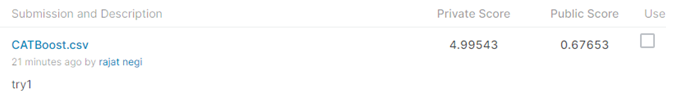

## Summary

- the valid and test scores are around 0.60 for catboost
- but private score in kaggle is 4.9

### XGBoost

In [ ]:
learning_rate= [0.075, 0.05, 0.01, 0.1, 1]
max_depth= [3, 5, 7, 9, 10]
n_estimators= [100, 150, 200, 300, 500]

for eta in learning_rate:
  for est in n_estimators:
    for depth in max_depth:

      xgb = XGBRegressor(n_jobs= -1, learning_rate= eta, max_depth= depth, n_estimators= est)
      xgb.fit(X_train, y_train)

      valid_predict= xgb.predict(X_valid).reshape(-1,28)
      valid_predict= pd.DataFrame(valid_predict, columns= f_cols)
      valid_predict['id']= uid
      cols= ['id'] + f_cols
      valid_predict= valid_predict[cols]
      valid_wrmsse= wrmsse(sales, valid_predict, True)

      test_predict= xgb.predict(X_test).reshape(-1,28)
      test_predict= pd.DataFrame(test_predict, columns= f_cols)
      test_predict['id']= uid
      cols= ['id'] + f_cols
      test_predict= test_predict[cols]
      eval_wrmsse= wrmsse(sales, test_predict, False)

      print('\n')
      print("#"*100)
      print(f"for validation= \n eta: {eta}, n_estimators: {est}, max_depth= {depth}, WRMSSE:{valid_wrmsse}")
      print(f"for evaluation= \n eta: {eta}, n_estimators: {est}, max_depth= {depth}, WRMSSE:{eval_wrmsse}")
      print("#"*100)
      print('\n')
            

[19:30:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:30:34] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


####################################################################################################
for validation= 
 eta: 0.001, n_estimators: 100, max_depth= 3, WRMSSE:3.275084488761455
for evaluation= 
 eta: 0.001, n_estimators: 100, max_depth= 3, WRMSSE:3.4040175964836266
####################################################################################################


[19:56:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:56:17] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact 

In [ ]:
valid_predict= xgb.predict(X_valid).reshape(-1,28)
valid_predict= pd.DataFrame(valid_predict, columns= f_cols)
valid_predict['id']= uid
cols= ['id'] + f_cols
valid_predict= valid_predict[cols]

print("valid: ",wrmsse(sales, valid_predict, True))

test_predict= xgb.predict(X_test).reshape(-1,28)
test_predict= pd.DataFrame(test_predict, columns= f_cols)
test_predict['id']= uid
cols= ['id'] + f_cols
test_predict= test_predict[cols]

print("test: ",wrmsse(sales, test_predict, False))

valid:  0.8342303055290955
test:  5.401422201145426


In [14]:
store_dict= dict(zip(df_df.store_id.unique(), sales.store_id.unique()))

In [1]:
# GRID SEARCH CV
XGB_grid_models=[] #will store models for all iterations
learning_rate= [0.001, 0.01, 0.1, 1]
max_depth= [3, 5, 7, 10]
n_estimators= [100, 200, 300, 500, 800, 1000]


for eta in learning_rate:
  for est in n_estimators:
    for depth in max_depth:
        mod=[] #will store models for this iteration
        # print(f"No of times remaining: {20 - (i+1)}")
        validation_prediction= pd.DataFrame(columns= ['id']+ f_cols)
        test_prediction= pd.DataFrame(columns= ['id']+ f_cols)
            
        for store in list(df_df.store_id.unique()):

            print("-"*110)
            print(f"store {store + 1}: {store_dict[store]}, eta: {eta}, n_estimators: {est}, max_depth: {depth}")
            print("-"*110)

            data= df_df[df_df['store_id']== store] #getting data by store

            #creating train and test datasets
            train= data[data['d'] <= 1885].drop(['id','d'], axis= 1)
            valid= data[(data['d'] >1885) & (data['d']<1914)].drop('d', axis= 1)
            test= data[(data['d']>= 1914) & (data['d'] <= 1941)].drop('d', axis= 1)

            #getting the ids of valid and test datasets so as to sort them afterwords
            valid_id= list(valid['id'].values)
            test_id= list(test['id'].values)

            #dropping id now 
            valid.drop('id', axis= 1, inplace= True)
            test.drop('id', axis= 1, inplace= True)

            X_train, y_train= train.drop('sales', axis= 1), train['sales']
            X_valid, y_valid= valid.drop('sales', axis= 1), valid['sales']
            X_test, y_test= test.drop('sales', axis= 1), test['sales']
    #         X_eval, y_eval= evaluation.drop('sales', axis= 1), evaluation['sales']


            model = XGBRegressor(n_jobs= -1, learning_rate= eta, max_depth= depth, n_estimators= est)
            model.fit(X_train, y_train)

            mod.append(model) #appending model

            #predicting validation and test data
            valid_predict= model.predict(X_valid).reshape(-1,28)
            valid_predict= pd.DataFrame(valid_predict, columns= f_cols)
            valid_predict['id']= valid_id[::28] #adding ids
            cols= ['id'] + f_cols
            valid_predict= valid_predict[cols]

            #concatinating it with larger dataset for computing WRMSSE
            validation_prediction= pd.concat([validation_prediction, valid_predict]) 


            test_predict= model.predict(X_test).reshape(-1,28)
            test_predict= pd.DataFrame(test_predict, columns= f_cols)
            test_predict['id']= test_id[::28] #adding ids
            cols= ['id'] + f_cols
            test_predict= test_predict[cols]

            #concatinating it with larger dataset for computing WRMSSE
            test_prediction= pd.concat([test_prediction, test_predict]) 

        XGB_grid_models.append(mod)#appending all models in this iteration

        #sorting them by ids 
    #     validation_prediction= validation_prediction.sort_values(by= 'id')
        validation_prediction['id']= validation_prediction['id'].apply(lambda x: id_dict[x])

    #     test_prediction= test_prediction.sort_values(by= 'id')
        test_prediction['id']= test_prediction['id'].apply(lambda x: id_dict[x])

        print('calculating WRMSSE')
        #calculating validation and evaluation wrmsse
        valid_wrmsse= wrmsse(sales, validation_prediction, True)

        eval_wrmsse= wrmsse(sales, test_prediction, False)

        print('\n')
        print("#"*100)
        print(f"for validation= \n eta: {eta}, n_estimators: {est}, max_depth: {depth}, WRMSSE:{valid_wrmsse}")
        print(f"for evaluation= \n eta: {eta}, n_estimators: {est}, max_depth: {depth}, WRMSSE:{eval_wrmsse}")
        print("#"*100)
        print('\n')
        print("-+-"*35)
        print("-+-"*35)
        print('\n')
        
        del validation_prediction, test_prediction, X_train, X_test, X_valid, train, valid, test
        gc.collect()

NameError: ignored

In [15]:
store_dict= dict(zip(df_df.store_id.unique(), sales.store_id.unique()))
uid_df= pd.DataFrame(uid, columns=['id'])

In [ ]:
# RANDOMIZED SEARCH CV
import random
XGB_random_models=[] #will store models for all iterations
predicted_values_validation=[]

learning_rate= [0.001, 0.01, 0.1, 1]
max_depth= [3, 5, 7, 10]
n_estimators= [100, 200, 300, 500, 800, 1000]

for i in range(20):
  mod=[] #will store models for this iteration
  print(f"No of times remaining: {20 - (i+1)}")
  validation_prediction= pd.DataFrame(columns= ['id']+ f_cols)
  test_prediction= pd.DataFrame(columns= ['id']+ f_cols)

  for store in list(df_df.store_id.unique()):
      eta= random.choice(learning_rate)
      est= random.choice(n_estimators)
      depth= random.choice(max_depth)
            
      print("-"*110)
      print(f"store {store + 1}: {store_dict[store]}, eta: {eta}, n_estimators: {est}, max_depth: {depth}")
      print("-"*110)

      data= df_df[df_df['store_id']== store] #getting data by store

      #creating train and test datasets
      train= data[data['d'] <= 1885].drop(['id','d'], axis= 1)
      valid= data[(data['d'] >1885) & (data['d']<1914)].drop('d', axis= 1)
      test= data[(data['d']>= 1914) & (data['d'] <= 1941)].drop('d', axis= 1)

      #getting the ids of valid and test datasets so as to sort them afterwords
      valid_id= list(valid['id'].values)
      test_id= list(test['id'].values)

      #dropping id now 
      valid.drop('id', axis= 1, inplace= True)
      test.drop('id', axis= 1, inplace= True)

      X_train, y_train= train.drop('sales', axis= 1), train['sales']
      X_valid, y_valid= valid.drop('sales', axis= 1), valid['sales']
      X_test, y_test= test.drop('sales', axis= 1), test['sales']
#         X_eval, y_eval= evaluation.drop('sales', axis= 1), evaluation['sales']


      model = XGBRegressor(n_jobs= -1, learning_rate= eta, max_depth= depth, n_estimators= est)
      model.fit(X_train, y_train)

      mod.append(model) #appending model

      #predicting validation and test data
      valid_predict= model.predict(X_valid).reshape(-1,28)
      valid_predict= pd.DataFrame(valid_predict, columns= f_cols)
      valid_predict['id']= valid_id[::28] #adding ids
      cols= ['id'] + f_cols
      valid_predict= valid_predict[cols]

      #concatinating it with larger dataset for computing WRMSSE
      validation_prediction= pd.concat([validation_prediction, valid_predict]) 


      test_predict= model.predict(X_test).reshape(-1,28)
      test_predict= pd.DataFrame(test_predict, columns= f_cols)
      test_predict['id']= test_id[::28] #adding ids
      cols= ['id'] + f_cols
      test_predict= test_predict[cols]

      #concatinating it with larger dataset for computing WRMSSE
      test_prediction= pd.concat([test_prediction, test_predict]) 
      
      test_prediction= uid_df.merge(test_prediction, on= 'id', how= 'left')
      
      predicted_values_validation.append(test_prediction)



  XGB_random_models.append(mod)#appending all models in this iteration

  #sorting them by ids 
#     validation_prediction= validation_prediction.sort_values(by= 'id')
  validation_prediction['id']= validation_prediction['id'].apply(lambda x: id_dict[x])

#     test_prediction= test_prediction.sort_values(by= 'id')
  test_prediction['id']= test_prediction['id'].apply(lambda x: id_dict[x])

  print('calculating WRMSSE')
  #calculating validation and evaluation wrmsse
  valid_wrmsse= wrmsse(sales, validation_prediction, True)

  eval_wrmsse= wrmsse(sales, test_prediction, False)

  print('\n')
  print("#"*100)
  print(f"for validation= \n eta: {eta}, n_estimators: {est}, max_depth: {depth}, WRMSSE:{valid_wrmsse}")
  print(f"for evaluation= \n eta: {eta}, n_estimators: {est}, max_depth: {depth}, WRMSSE:{eval_wrmsse}")
  print("#"*100)
  print('\n')
  print("-+-"*35)
  print("-+-"*35)
  print('\n')
  del validation_prediction, test_prediction, X_train, X_test, X_valid, train, valid, test
  gc.collect()

No of times remaining: 19
--------------------------------------------------------------------------------------------------------------
store 1: CA_1, eta: 0.1, n_estimators: 100, max_depth: 3
--------------------------------------------------------------------------------------------------------------
[06:08:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------------------------------------------------------------------------------------------------
store 2: CA_2, eta: 1, n_estimators: 1000, max_depth: 3
--------------------------------------------------------------------------------------------------------------
[06:09:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------------------------------------------------------------------------------------------------
store 3: CA_3, eta: 1, n_estimators: 1000, max_depth